In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow	import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV


from scikeras.wrappers import KerasClassifier, KerasRegressor

In [2]:
dataset = pd.read_csv('admissions_data.csv')
print(dataset.shape)
print(dataset.head())
print(dataset.columns)
print(dataset.iloc[:,:5].describe())
print(dataset.iloc[:,5:].describe())

(500, 9)
   Serial No.  GRE Score  TOEFL Score  University Rating  SOP  LOR   CGPA  \
0           1        337          118                  4  4.5   4.5  9.65   
1           2        324          107                  4  4.0   4.5  8.87   
2           3        316          104                  3  3.0   3.5  8.00   
3           4        322          110                  3  3.5   2.5  8.67   
4           5        314          103                  2  2.0   3.0  8.21   

   Research  Chance of Admit   
0         1              0.92  
1         1              0.76  
2         1              0.72  
3         1              0.80  
4         0              0.65  
Index(['Serial No.', 'GRE Score', 'TOEFL Score', 'University Rating', 'SOP',
       'LOR ', 'CGPA', 'Research', 'Chance of Admit '],
      dtype='object')
       Serial No.   GRE Score  TOEFL Score  University Rating         SOP
count  500.000000  500.000000   500.000000         500.000000  500.000000
mean   250.500000  316.472000   1

In [3]:
dataset = dataset.drop(columns=['Serial No.'])
print(dataset.columns)


#Séparation du dataset
features = dataset.iloc[:,:-1]
labels = dataset.iloc[:,-1]

features_train, features_test, labels_train, labels_test = train_test_split(features, labels, test_size = 0.3, random_state=42 )

#Standarisation
scaler = StandardScaler()
features_train =scaler.fit_transform(features_train)
features_test=scaler.transform(features_test)

Index(['GRE Score', 'TOEFL Score', 'University Rating', 'SOP', 'LOR ', 'CGPA',
       'Research', 'Chance of Admit '],
      dtype='object')


In [4]:

def plot(history):
    fig, axs = plt.subplots(1, 2, gridspec_kw={'hspace': 1, 'wspace': 0.8}) 
    (ax1, ax2) = axs
    ax1.plot(history.history['loss'], label='train')
    ax1.plot(history.history['val_loss'], label='validation')
#     ax1.set_title('lrate=' + str(learning_rate))
    ax1.legend(loc="upper right")
    ax1.set_xlabel("# of epochs")
    ax1.set_ylabel("loss (mse)")

    ax2.plot(history.history['mae'], label='train')
    ax2.plot(history.history['val_mae'], label='validation')
#     ax2.set_title('lrate=' + str(learning_rate))
    ax2.legend(loc="upper right")
    ax2.set_xlabel("# of epochs")
    ax2.set_ylabel("MAE")
    print("Final training MAE:", history.history['mae'][-1])
    print("Final validation MAE:", history.history['val_mae'][-1])

/Users/victorchau/opt/anaconda3/lib/python3.9/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Epoch 62: early stopping
Final training MAE: 0.04415062069892883
Final validation MAE: 0.049352094531059265


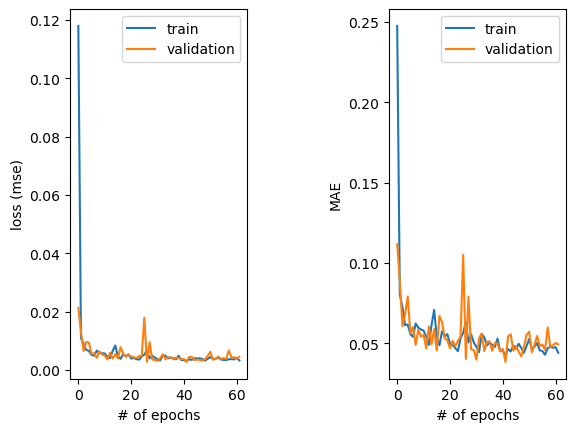

In [5]:
#Modèle basique  (1 hidden layer)
model = Sequential()
input = layers.InputLayer(input_shape=(features_train.shape[1],))
model.add(input)
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1))
opt= Adam(learning_rate=0.01)
model.compile(loss='mse', metrics=['mae'], optimizer=opt)

#EarlyStopping
es = EarlyStopping(monitor='val_loss',mode = 'min', verbose=1, patience=20)

#Train
history = model.fit(features_train, labels_train, epochs= 100, batch_size = 5 ,verbose =0, validation_split=0.2,callbacks=[es])

plot(history)
plt.show()

Epoch 58: early stopping
Final training MAE: 0.05268513038754463
Final validation MAE: 0.06845837831497192


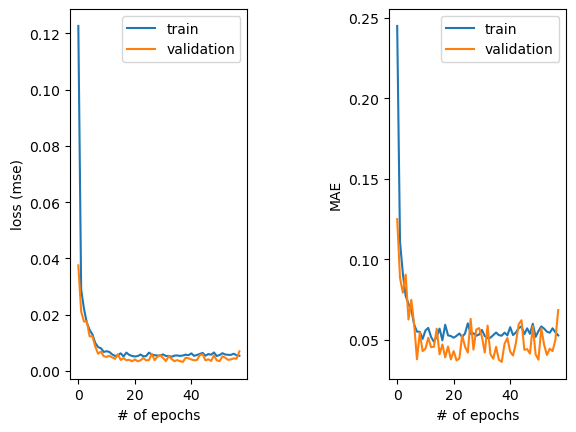

In [6]:
#Modèle complexe avec Dropout et L2 Regularization
model = Sequential()
model.add(layers.InputLayer(input_shape=(features_train.shape[1],)))
model.add(layers.Dense(128, activation='relu', kernel_regularizer=l2(0.001)))  # L2 regularization
model.add(layers.Dropout(0.3))  
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1))  
opt= Adam(learning_rate=0.01)
model.compile(loss='mse', metrics=['mae'], optimizer=opt)

#EarlyStopping
es = EarlyStopping(monitor='val_loss',mode = 'min', verbose=1, patience=20)

#Train
history = model.fit(features_train, labels_train, epochs= 100, batch_size = 5 ,verbose =0, validation_split=0.2, callbacks=[es])

plot(history)
plt.show()

In [15]:
def design_model(learning_rate=0.001):
    model = Sequential()
    model.add(layers.InputLayer(input_shape=(features_train.shape[1],)))
    model.add(layers.Dense(128, activation='relu', kernel_regularizer=l2(0.001)))  # L2 regularization
    model.add(layers.Dropout(0.3))  
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1))  
    opt= Adam(learning_rate=learning_rate)
    model.compile(loss='mse', metrics=['mae'], optimizer=opt)
    return model


# Wrap the fixed model in KerasRegressor
model = KerasRegressor(model=design_model, epochs=100, batch_size=5, verbose=0)




# Define the grid of hyperparameters
param_grid = {
    'model__learning_rate': [0.001, 0.01, 0.1],  # Learning rates to try
    'batch_size': [5, 10, 20],  # Batch sizes to try
}

es = EarlyStopping(monitor='val_loss',mode = 'min', verbose=1, patience=20)

grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)

grid_result = grid.fit(features_train, labels_train, callbacks=[es])

# Print the best parameters and results
print(f"Best Parameters: {grid_result.best_params_}")
print(f"Best Validation Score (MAE): {grid_result.best_score_}")



/Users/victorchau/opt/anaconda3/lib/python3.9/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(
/Users/victorchau/opt/anaconda3/lib/python3.9/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(
/Users/victorchau/opt/anaconda3/lib/python3.9/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(
/Users/victorchau/opt/anaconda3/lib/python3.9/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(
/Users/victorchau/opt/anaconda3/lib/python3.9/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(
/Users/victorchau/opt/anaconda3/lib/python3.9/site

/Users/victorchau/opt/anaconda3/lib/python3.9/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(
/Users/victorchau/opt/anaconda3/lib/python3.9/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(
/Users/victorchau/opt/anaconda3/lib/python3.9/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(
/Users/victorchau/opt/anaconda3/lib/python3.9/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(
/Users/victorchau/opt/anaconda3/lib/python3.9/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(
/Users/victorchau/opt/anaconda3/lib/python3.9/site

Best Parameters: {'batch_size': 20, 'model__learning_rate': 0.001}
Best Validation Score (MAE): 0.7764397658904332


Epoch 1/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1553 - mae: 0.3187 - val_loss: 0.0537 - val_mae: 0.1583
Epoch 2/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0720 - mae: 0.1984 - val_loss: 0.0470 - val_mae: 0.1540
Epoch 3/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0555 - mae: 0.1640 - val_loss: 0.0360 - val_mae: 0.1193
Epoch 4/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0418 - mae: 0.1362 - val_loss: 0.0366 - val_mae: 0.1278
Epoch 5/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0343 - mae: 0.1111 - val_loss: 0.0331 - val_mae: 0.1176
Epoch 6/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0378 - mae: 0.1256 - val_loss: 0.0270 - val_mae: 0.0923
Epoch 7/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0383 - mae: 0.1233 - val_loss: 0.0344 - val_mae: 0.1245
Epoch 8/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0386 - mae: 0.1241 - val_loss: 0.0284 - val_mae: 0.1032
Epoch 9/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.033

Epoch 55/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0109 - mae: 0.0484 - val_loss: 0.0120 - val_mae: 0.0617
Epoch 56/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0109 - mae: 0.0508 - val_loss: 0.0125 - val_mae: 0.0662
Epoch 57/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0108 - mae: 0.0495 - val_loss: 0.0116 - val_mae: 0.0597
Epoch 58/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0113 - mae: 0.0532 - val_loss: 0.0098 - val_mae: 0.0437
Epoch 59/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0104 - mae: 0.0477 - val_loss: 0.0104 - val_mae: 0.0517
Epoch 60/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0104 - mae: 0.0507 - val_loss: 0.0107 - val_mae: 0.0553
Epoch 61/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0103 - mae: 0.0500 - val_loss: 0.0100 - val_mae: 0.0498
Epoch 62/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0095 - mae: 0.0442 - val_loss: 0.0108 - val_mae: 0.0577
Epoch 63/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - lo

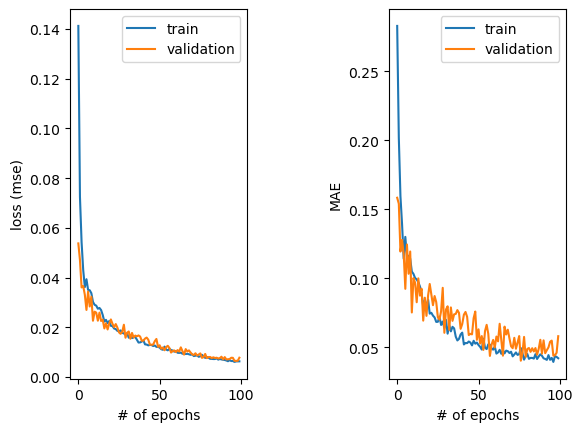

In [16]:
# Train the final model with the best parameters
best_lr = grid_result.best_params_['model__learning_rate']
best_batch_size = grid_result.best_params_['batch_size']

final_model = design_model(learning_rate=best_lr)
es = EarlyStopping(monitor='val_loss',mode = 'min', verbose=1, patience=20)
history = final_model.fit(
    features_train, 
    labels_train, 
    batch_size=best_batch_size, 
    epochs=100, 
    validation_split=0.2, 
    verbose=1,
    callbacks=[es]
)

plot(history)

In [19]:
# evaluate the model
val_mse, val_mae = final_model.evaluate(features_test, labels_test, verbose = 0)

# view the MAE performance
print("MAE: ", val_mae)

# evauate r-squared score
y_pred = final_model.predict(features_test)

print("R2: ", r2_score(labels_test,y_pred))


MAE:  0.052595969289541245
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 814us/step
R2:  0.7874444058950874
